# Regression

Here, we test approach to learn known solution to the ODE in some points by training the neural network. 

Thus, the approximation for each X(t), Y(t), Z(t) is builded.

Then, neural network can be easily differentiated and we can compute all the derivatives.

In [84]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm.notebook import tqdm

In [2]:
import pickle

In [3]:
with open('data.pickle', 'rb') as f:
    data = pickle.load(f)

In [4]:
xs, ys, zs = data['xs'], data['ys'], data['zs']
dx, dy, dz = data['dx'], data['dy'], data['dz']

In [5]:
dt = data['dt']
t = np.linspace(0, dt * (len(xs)-1), len(xs))
f = np.linspace(0, 1/dt, len(t))
w = 2 * np.pi * f

In [143]:
sp = 10 # sparse parameter for data that are to be trained
x_test, y_test = t, np.array([xs, ys, zs]).T

x_train = x_test[::sp]
y_train = y_test[::sp]

In [156]:
dy_test = np.array([dx, dy, dz]).T

In [172]:
Tanh = L.Lambda(lambda x: tf.math.tanh(x))
iDense = L.Lambda(lambda x: (1.0 - x[0]) * x[1] + x[0] * x[2], name='iDense') # [Z, U, V]

class AdaptTanh(L.Layer):
    def __init__(self, n, **kwargs):
        super(AdaptTanh, self).__init__(**kwargs)
        self.n = n
        self.a = self.add_weight(name='a', 
                                 shape=(1,),
                                 initializer='ones',
                                 trainable=True) 
    def call(self, X):
        return tf.math.tanh(self.n * self.a * X)
    
class Sine(L.Layer):
    def __init__(self, **kwargs):
        super(Sine, self).__init__(**kwargs)

    def call(self, X):
        return tf.math.sin(X)

def initer(w0, wn): 
    def kernel_init(shape, dtype=None):
        n1, n2 = shape
        return tf.linspace([w0]*n1, [wn]*n1, n2, axis=1)
    return kernel_init

In [199]:
Diff = L.Lambda(lambda x: tf.gradients(x[0], x[1])[0])

def NNmodel(nl=3, nu=100, indim=1, outdim=3, UV=False, act=Sine(), resnet=False, initializer=None,
           regularizer=None):
    t = L.Input((indim,), name='t')

    outs = []
    for k in range(outdim):
        x = L.Dense(nu, activation=act, kernel_initializer=initializer, 
                    kernel_regularizer=regularizer)(t)
        for i in range(nl - 1):
            y = L.Dense(nu, activation=act, kernel_initializer=initializer, 
                        kernel_regularizer=regularizer)(x)
            x = y
        X = L.Dense(1, activation='linear', kernel_initializer='ones')(x)
        outs.append(X)
    
    if len(outs) > 1: Y = L.Concatenate()(outs)
    else: Y = outs
    Ym = Model(inputs=t, outputs=Y)
    
    dY = [Diff([yi, t]) for yi in outs]
    if len(outs) > 1: dY = L.Concatenate()(dY)
    dYm = Model(inputs=t, outputs=dY)
    
    return Ym, dYm

In [200]:
freq_init = initer(0.0, 20.0)
reg = regularizers.l1(0.01)

Y, dY = NNmodel(nl=1, nu=1000, indim=1, outdim=3, UV=False, act=Sine(), 
                initializer=freq_init, regularizer=reg)

In [205]:
adam = tf.keras.optimizers.Adam(learning_rate=5e-3, decay=1e-4)
Y.compile(optimizer=adam, loss='mse')

In [206]:
h = Y.fit(x=x_train, y=y_train, 
            epochs=2000, 
            verbose=2, 
            batch_size=512,)

Epoch 1/2000
20/20 - 0s - loss: 304.2235
Epoch 2/2000
20/20 - 0s - loss: 299.8875
Epoch 3/2000
20/20 - 0s - loss: 298.6429
Epoch 4/2000
20/20 - 0s - loss: 298.2747
Epoch 5/2000
20/20 - 0s - loss: 298.2109
Epoch 6/2000
20/20 - 0s - loss: 298.1161
Epoch 7/2000
20/20 - 0s - loss: 298.1252
Epoch 8/2000
20/20 - 0s - loss: 298.1524
Epoch 9/2000
20/20 - 0s - loss: 298.2298
Epoch 10/2000
20/20 - 0s - loss: 298.0044
Epoch 11/2000
20/20 - 0s - loss: 297.9683
Epoch 12/2000
20/20 - 0s - loss: 297.9225
Epoch 13/2000
20/20 - 0s - loss: 297.6424
Epoch 14/2000
20/20 - 0s - loss: 297.5941
Epoch 15/2000
20/20 - 0s - loss: 297.8131
Epoch 16/2000
20/20 - 0s - loss: 297.7831
Epoch 17/2000
20/20 - 0s - loss: 297.6377
Epoch 18/2000
20/20 - 0s - loss: 297.3293
Epoch 19/2000
20/20 - 0s - loss: 297.1292
Epoch 20/2000
20/20 - 0s - loss: 296.9546
Epoch 21/2000
20/20 - 0s - loss: 297.0356
Epoch 22/2000
20/20 - 0s - loss: 297.0143
Epoch 23/2000
20/20 - 0s - loss: 296.7486
Epoch 24/2000
20/20 - 0s - loss: 296.6268
E

20/20 - 0s - loss: 269.7139
Epoch 195/2000
20/20 - 0s - loss: 269.4622
Epoch 196/2000
20/20 - 0s - loss: 269.2482
Epoch 197/2000
20/20 - 0s - loss: 269.1055
Epoch 198/2000
20/20 - 0s - loss: 268.9376
Epoch 199/2000
20/20 - 0s - loss: 268.6861
Epoch 200/2000
20/20 - 0s - loss: 268.5258
Epoch 201/2000
20/20 - 0s - loss: 268.2268
Epoch 202/2000
20/20 - 0s - loss: 268.0408
Epoch 203/2000
20/20 - 0s - loss: 267.7652
Epoch 204/2000
20/20 - 0s - loss: 267.5079
Epoch 205/2000
20/20 - 0s - loss: 267.2860
Epoch 206/2000
20/20 - 0s - loss: 267.0890
Epoch 207/2000
20/20 - 0s - loss: 266.8766
Epoch 208/2000
20/20 - 0s - loss: 266.7179
Epoch 209/2000
20/20 - 0s - loss: 266.4390
Epoch 210/2000
20/20 - 0s - loss: 266.2204
Epoch 211/2000
20/20 - 0s - loss: 266.0046
Epoch 212/2000
20/20 - 0s - loss: 265.7704
Epoch 213/2000
20/20 - 0s - loss: 265.6086
Epoch 214/2000
20/20 - 0s - loss: 265.3242
Epoch 215/2000
20/20 - 0s - loss: 265.0752
Epoch 216/2000
20/20 - 0s - loss: 264.8813
Epoch 217/2000
20/20 - 0s 

Epoch 385/2000
20/20 - 0s - loss: 220.8075
Epoch 386/2000
20/20 - 0s - loss: 220.5620
Epoch 387/2000
20/20 - 0s - loss: 220.2959
Epoch 388/2000
20/20 - 0s - loss: 219.9953
Epoch 389/2000
20/20 - 0s - loss: 219.7122
Epoch 390/2000
20/20 - 0s - loss: 219.3968
Epoch 391/2000
20/20 - 0s - loss: 219.1446
Epoch 392/2000
20/20 - 0s - loss: 218.9095
Epoch 393/2000
20/20 - 0s - loss: 218.6264
Epoch 394/2000
20/20 - 0s - loss: 218.3697
Epoch 395/2000
20/20 - 0s - loss: 218.0350
Epoch 396/2000
20/20 - 0s - loss: 217.7670
Epoch 397/2000
20/20 - 0s - loss: 217.4958
Epoch 398/2000
20/20 - 0s - loss: 217.2269
Epoch 399/2000
20/20 - 0s - loss: 216.9962
Epoch 400/2000
20/20 - 0s - loss: 216.6746
Epoch 401/2000
20/20 - 0s - loss: 216.3919
Epoch 402/2000
20/20 - 0s - loss: 216.1111
Epoch 403/2000
20/20 - 0s - loss: 215.8428
Epoch 404/2000
20/20 - 0s - loss: 215.6056
Epoch 405/2000
20/20 - 0s - loss: 215.3035
Epoch 406/2000
20/20 - 0s - loss: 214.9848
Epoch 407/2000
20/20 - 0s - loss: 214.6803
Epoch 408/2

Epoch 576/2000
20/20 - 0s - loss: 171.6625
Epoch 577/2000
20/20 - 0s - loss: 171.4670
Epoch 578/2000
20/20 - 0s - loss: 171.2769
Epoch 579/2000
20/20 - 0s - loss: 171.0233
Epoch 580/2000
20/20 - 0s - loss: 170.7957
Epoch 581/2000
20/20 - 0s - loss: 170.5816
Epoch 582/2000
20/20 - 0s - loss: 170.3580
Epoch 583/2000
20/20 - 0s - loss: 170.1340
Epoch 584/2000
20/20 - 0s - loss: 169.8994
Epoch 585/2000
20/20 - 0s - loss: 169.6557
Epoch 586/2000
20/20 - 0s - loss: 169.4454
Epoch 587/2000
20/20 - 0s - loss: 169.2219
Epoch 588/2000
20/20 - 0s - loss: 169.0611
Epoch 589/2000
20/20 - 0s - loss: 168.8359
Epoch 590/2000
20/20 - 0s - loss: 168.5922
Epoch 591/2000
20/20 - 0s - loss: 168.4038
Epoch 592/2000
20/20 - 0s - loss: 168.1769
Epoch 593/2000
20/20 - 0s - loss: 167.9528
Epoch 594/2000
20/20 - 0s - loss: 167.7425
Epoch 595/2000
20/20 - 0s - loss: 167.5528
Epoch 596/2000
20/20 - 0s - loss: 167.3431
Epoch 597/2000
20/20 - 0s - loss: 167.1071
Epoch 598/2000
20/20 - 0s - loss: 166.9205
Epoch 599/2

Epoch 767/2000
20/20 - 0s - loss: 138.9640
Epoch 768/2000
20/20 - 0s - loss: 138.8376
Epoch 769/2000
20/20 - 0s - loss: 138.7286
Epoch 770/2000
20/20 - 0s - loss: 138.5955
Epoch 771/2000
20/20 - 0s - loss: 138.4336
Epoch 772/2000
20/20 - 0s - loss: 138.3119
Epoch 773/2000
20/20 - 0s - loss: 138.1746
Epoch 774/2000
20/20 - 0s - loss: 138.0726
Epoch 775/2000
20/20 - 0s - loss: 137.9811
Epoch 776/2000
20/20 - 0s - loss: 137.8412
Epoch 777/2000
20/20 - 0s - loss: 137.7254
Epoch 778/2000
20/20 - 0s - loss: 137.5953
Epoch 779/2000
20/20 - 0s - loss: 137.4637
Epoch 780/2000
20/20 - 0s - loss: 137.3580
Epoch 781/2000
20/20 - 0s - loss: 137.2171
Epoch 782/2000
20/20 - 0s - loss: 137.1120
Epoch 783/2000
20/20 - 0s - loss: 137.0061
Epoch 784/2000
20/20 - 0s - loss: 136.8500
Epoch 785/2000
20/20 - 0s - loss: 136.7457
Epoch 786/2000
20/20 - 0s - loss: 136.6258
Epoch 787/2000
20/20 - 0s - loss: 136.4918
Epoch 788/2000
20/20 - 0s - loss: 136.3990
Epoch 789/2000
20/20 - 0s - loss: 136.2688
Epoch 790/2

Epoch 958/2000
20/20 - 0s - loss: 121.4197
Epoch 959/2000
20/20 - 0s - loss: 121.3528
Epoch 960/2000
20/20 - 0s - loss: 121.2745
Epoch 961/2000
20/20 - 0s - loss: 121.2039
Epoch 962/2000
20/20 - 0s - loss: 121.1319
Epoch 963/2000
20/20 - 0s - loss: 121.0700
Epoch 964/2000
20/20 - 0s - loss: 120.9919
Epoch 965/2000
20/20 - 0s - loss: 120.9090
Epoch 966/2000
20/20 - 0s - loss: 120.8548
Epoch 967/2000
20/20 - 0s - loss: 120.7962
Epoch 968/2000
20/20 - 0s - loss: 120.7245
Epoch 969/2000
20/20 - 0s - loss: 120.6649
Epoch 970/2000
20/20 - 0s - loss: 120.6090
Epoch 971/2000
20/20 - 0s - loss: 120.5767
Epoch 972/2000
20/20 - 0s - loss: 120.4894
Epoch 973/2000
20/20 - 0s - loss: 120.3934
Epoch 974/2000
20/20 - 0s - loss: 120.3458
Epoch 975/2000
20/20 - 0s - loss: 120.2804
Epoch 976/2000
20/20 - 0s - loss: 120.1927
Epoch 977/2000
20/20 - 0s - loss: 120.1304
Epoch 978/2000
20/20 - 0s - loss: 120.0732
Epoch 979/2000
20/20 - 0s - loss: 120.0189
Epoch 980/2000
20/20 - 0s - loss: 119.9444
Epoch 981/2

20/20 - 0s - loss: 111.7027
Epoch 1146/2000
20/20 - 0s - loss: 111.6682
Epoch 1147/2000
20/20 - 0s - loss: 111.6433
Epoch 1148/2000
20/20 - 0s - loss: 111.5794
Epoch 1149/2000
20/20 - 0s - loss: 111.5401
Epoch 1150/2000
20/20 - 0s - loss: 111.5037
Epoch 1151/2000
20/20 - 0s - loss: 111.4594
Epoch 1152/2000
20/20 - 0s - loss: 111.4208
Epoch 1153/2000
20/20 - 0s - loss: 111.3633
Epoch 1154/2000
20/20 - 0s - loss: 111.3228
Epoch 1155/2000
20/20 - 0s - loss: 111.2764
Epoch 1156/2000
20/20 - 0s - loss: 111.2521
Epoch 1157/2000
20/20 - 0s - loss: 111.2186
Epoch 1158/2000
20/20 - 0s - loss: 111.1688
Epoch 1159/2000
20/20 - 0s - loss: 111.1304
Epoch 1160/2000
20/20 - 0s - loss: 111.0920
Epoch 1161/2000
20/20 - 0s - loss: 111.0275
Epoch 1162/2000
20/20 - 0s - loss: 111.0052
Epoch 1163/2000
20/20 - 0s - loss: 110.9607
Epoch 1164/2000
20/20 - 0s - loss: 110.9127
Epoch 1165/2000
20/20 - 0s - loss: 110.8929
Epoch 1166/2000
20/20 - 0s - loss: 110.8456
Epoch 1167/2000
20/20 - 0s - loss: 110.8011
Epoc

Epoch 1332/2000
20/20 - 0s - loss: 105.4217
Epoch 1333/2000
20/20 - 0s - loss: 105.4072
Epoch 1334/2000
20/20 - 0s - loss: 105.3737
Epoch 1335/2000
20/20 - 0s - loss: 105.3432
Epoch 1336/2000
20/20 - 0s - loss: 105.2983
Epoch 1337/2000
20/20 - 0s - loss: 105.2823
Epoch 1338/2000
20/20 - 0s - loss: 105.2382
Epoch 1339/2000
20/20 - 0s - loss: 105.2155
Epoch 1340/2000
20/20 - 0s - loss: 105.1909
Epoch 1341/2000
20/20 - 1s - loss: 105.1636
Epoch 1342/2000
20/20 - 1s - loss: 105.1331
Epoch 1343/2000
20/20 - 0s - loss: 105.0993
Epoch 1344/2000
20/20 - 0s - loss: 105.0863
Epoch 1345/2000
20/20 - 0s - loss: 105.0616
Epoch 1346/2000
20/20 - 0s - loss: 105.0333
Epoch 1347/2000
20/20 - 0s - loss: 105.0182
Epoch 1348/2000
20/20 - 0s - loss: 105.0023
Epoch 1349/2000
20/20 - 0s - loss: 104.9565
Epoch 1350/2000
20/20 - 0s - loss: 104.9180
Epoch 1351/2000
20/20 - 0s - loss: 104.8958
Epoch 1352/2000
20/20 - 0s - loss: 104.8610
Epoch 1353/2000
20/20 - 0s - loss: 104.8431
Epoch 1354/2000
20/20 - 1s - los

20/20 - 1s - loss: 100.9810
Epoch 1519/2000
20/20 - 0s - loss: 100.9736
Epoch 1520/2000
20/20 - 0s - loss: 100.9545
Epoch 1521/2000
20/20 - 0s - loss: 100.9453
Epoch 1522/2000
20/20 - 1s - loss: 100.9164
Epoch 1523/2000
20/20 - 1s - loss: 100.9014
Epoch 1524/2000
20/20 - 0s - loss: 100.8954
Epoch 1525/2000
20/20 - 0s - loss: 100.8503
Epoch 1526/2000
20/20 - 0s - loss: 100.8362
Epoch 1527/2000
20/20 - 0s - loss: 100.8307
Epoch 1528/2000
20/20 - 0s - loss: 100.8005
Epoch 1529/2000
20/20 - 0s - loss: 100.7776
Epoch 1530/2000
20/20 - 0s - loss: 100.7603
Epoch 1531/2000
20/20 - 0s - loss: 100.7266
Epoch 1532/2000
20/20 - 0s - loss: 100.7220
Epoch 1533/2000
20/20 - 0s - loss: 100.6961
Epoch 1534/2000
20/20 - 0s - loss: 100.6753
Epoch 1535/2000
20/20 - 0s - loss: 100.6532
Epoch 1536/2000
20/20 - 1s - loss: 100.6486
Epoch 1537/2000
20/20 - 0s - loss: 100.6302
Epoch 1538/2000
20/20 - 0s - loss: 100.6094
Epoch 1539/2000
20/20 - 0s - loss: 100.6050
Epoch 1540/2000
20/20 - 1s - loss: 100.5585
Epoc

KeyboardInterrupt: 

In [207]:
y_pred = Y.predict(x_test)

In [208]:
abs(y_pred - y_test).mean() / abs(y_test).mean() * 100

4.9823379434403074

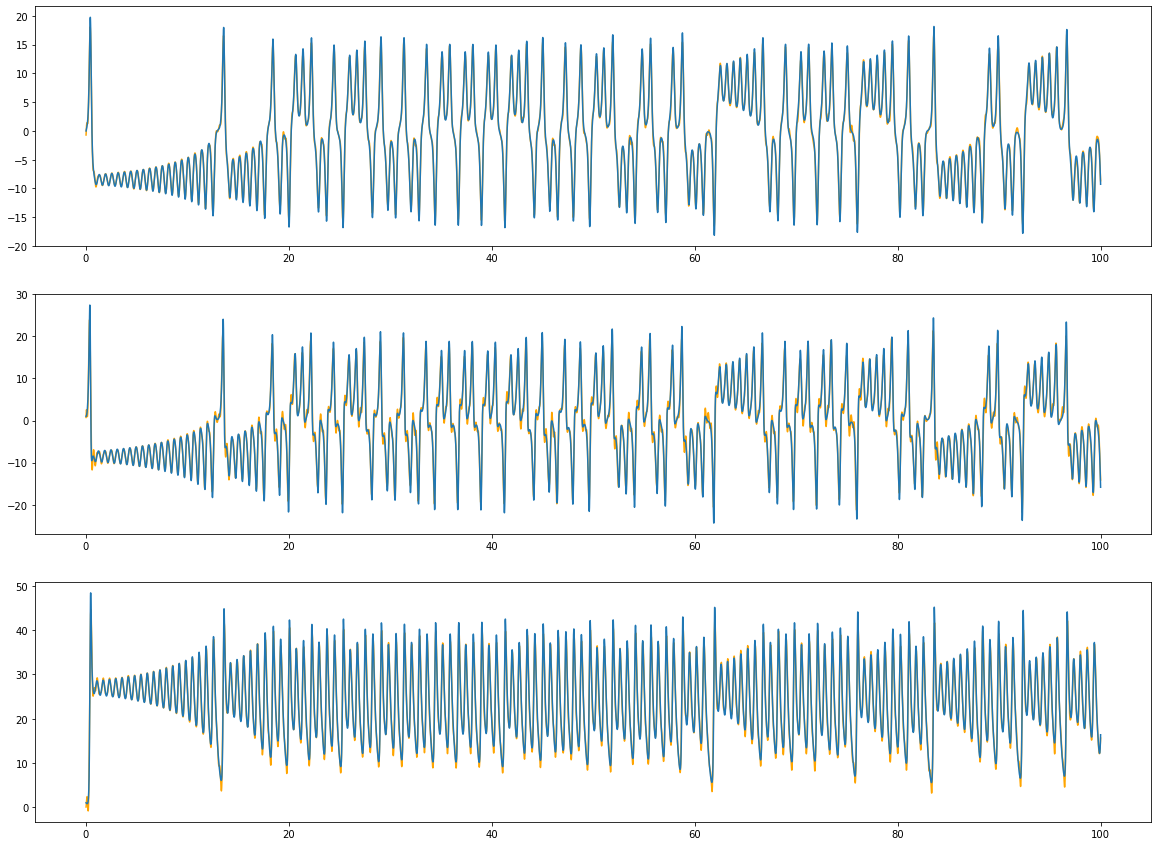

In [209]:
plt.figure(figsize=(20,15))
for i in range(3):
    plt.subplot(3,1, i+1)
    plt.plot(x_test, y_pred[:,i], c='orange')
    plt.plot(x_test, y_test[:,i])


In [210]:
dy_pred = dY.predict(x_test)

In [211]:
abs(dy_pred - dy_test).mean() / abs(dy_test).mean() * 100

30.576581652290578

In [212]:
dy_pred.shape

(100001, 3)

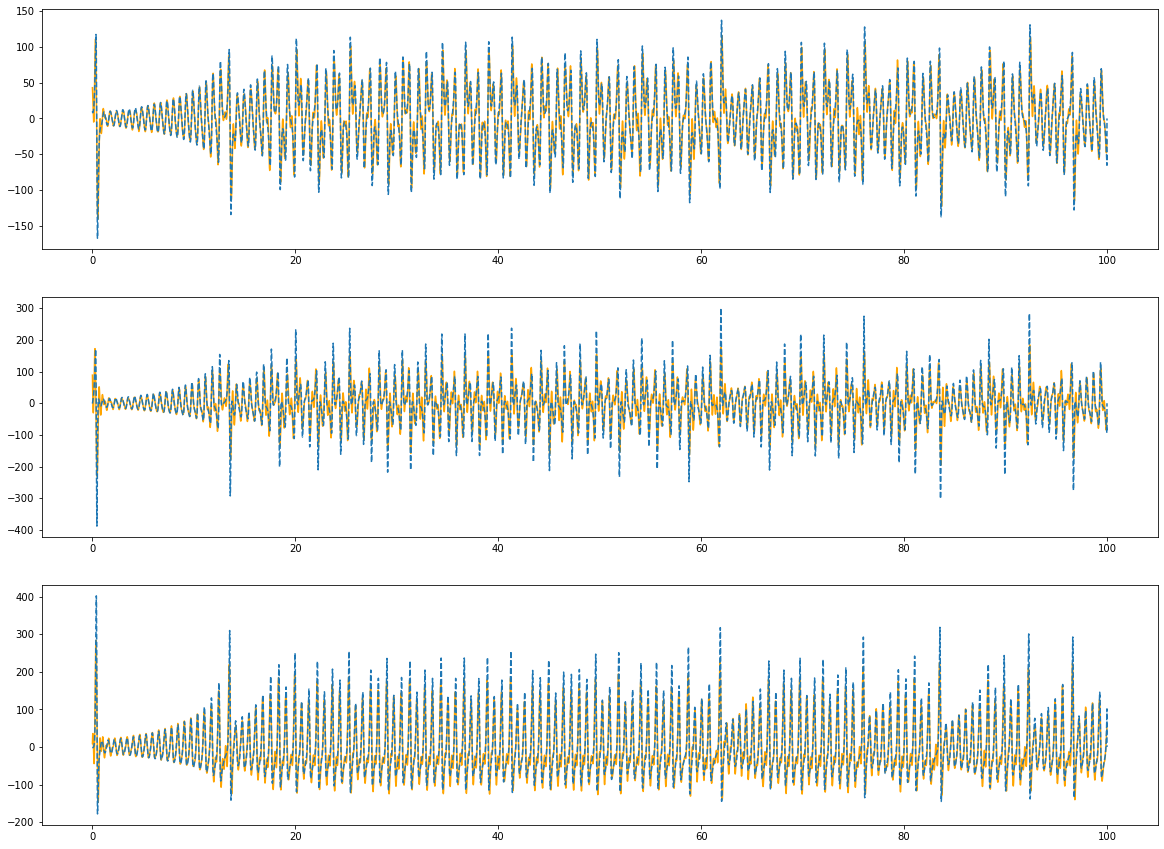

In [214]:
plt.figure(figsize=(20,15))
for i in range(3):
    plt.subplot(3,1, i+1)
    plt.plot(x_test, dy_pred[:,i], c='orange')
    plt.plot(x_test, dy_test[:,i], '--')


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=xs[::5], y=ys[::5], z=zs[::5], opacity=0.85,
                             name='original', mode='lines', line=dict(width=1)))
fig.add_trace(go.Scatter3d(x=y_pred[::5, 0], y=y_pred[::5, 1], z=y_pred[::5, 2], opacity=0.85,
                             name='neural network', mode='lines', line=dict(width=1)))
fig.update_layout(margin=dict(b=0, l=0, r=0, t=0))
fig.show()

In [226]:
fig.write_html('Attractor.html')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=dx[::5], y=dy[::5], z=dz[::5], opacity=0.85,
                             name='original', mode='lines', line=dict(width=1)))
fig.add_trace(go.Scatter3d(x=dy_pred[::5, 0], y=dy_pred[::5, 1], z=dy_pred[::5, 2], opacity=0.85,
                             name='neural network', mode='lines', line=dict(width=1)))
fig.update_layout(margin=dict(b=0, l=0, r=0, t=0))
fig.show()

In [224]:
fig.write_html('dAttractor.html')